## Draco MnGSeg analysis

In [1]:
import aplpy
from astropy.io import fits
%pylab inline

#plt.style.use(['dark_background'])

Populating the interactive namespace from numpy and matplotlib


INFO: Auto-setting vmin to -1.603e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.750e+01 [aplpy.core]


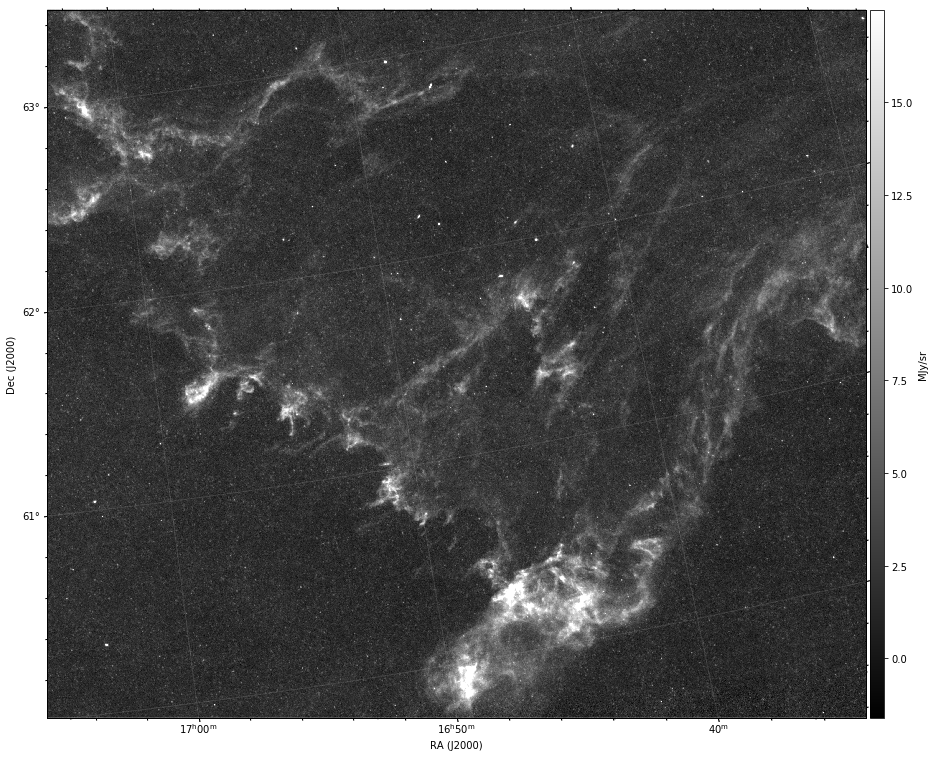

In [2]:
fig_all = plt.figure(1, figsize=(15,15))
figfile = '/Users/robitaij/postdoc/Herschel/OT/draco_250_rotate10_extract_hdrec.fits'
fig = aplpy.FITSFigure(figfile,figure=fig_all)
fig.show_colorscale(cmap='gray')
fig.add_colorbar()
fig.add_grid()
fig.grid.set_alpha(0.15)
fig.colorbar.set_axis_label_text(r'MJy/sr')

In [3]:
#Read map
HDU = fits.open(figfile)
im = HDU[0].data
header = HDU[0].header

In [4]:
from pywavan import fan_trans, apodize, padding, depad, powspec, gauss_beam

### Wavelet transforms and segmentation

In [11]:
#Resolution in arcmin
reso = HDU[0].header['CDELT2'] * 60.

na = im.shape[1]
nb = im.shape[0]
imzm = im - np.mean(im)

newdim = np.array([3000,3000])

#Apodization

tapper = apodize(nb,na,0.98)
imt = imzm *tapper
imr = padding(imt,newdim[0],newdim[1])

#Set a list of q
q=[]
q=[2.9]*28
#print q

#Wavelet power spectrum
wt, S11a, wav_k, S1a, q = fan_trans(imzm, reso=reso, q=q, qdyn=True, skewl=0.4, apodize= 0.98, arrdim = np.array(newdim))

3000 3000


### Beam in Fourier and wavelet space

In [16]:
#Beam Power spectrum
#FWHM = 18.2 / (60.*reso)  #Beam size at 250 micron
#beam = gauss_beam(FWHM,im.shape[0],im.shape[1],FWHM=True)
#beam = gauss_beam(FWHM,newdim[0],newdim[1],FWHM=True)
#tab_k, spec_beam = powspec(beam, reso=reso)
#spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beam, reso=reso, q=0, qdyn=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]

In [47]:
#Beam Power spectrum
HDUb = fits.open("/Users/robitaij/postdoc/Herschel/beams/empiral_spire_beam_250.fits")
beam = HDUb[0].data
beamr = padding(beam,newdim[1],newdim[0])
tab_k, spec_beam = powspec(beamr, reso=reso)
spec_beamn = spec_beam/spec_beam[0]  #Spectrum normalisation

Bwt, BS11a, Bwav_k, BS1a, Bq = fan_trans(beamr, reso=reso, q=0, qdyn=False, cutpad=False)
del Bwt,BS11a,Bq
BS1an = BS1a / BS1a[4]
BS1an[:4] = 1.0

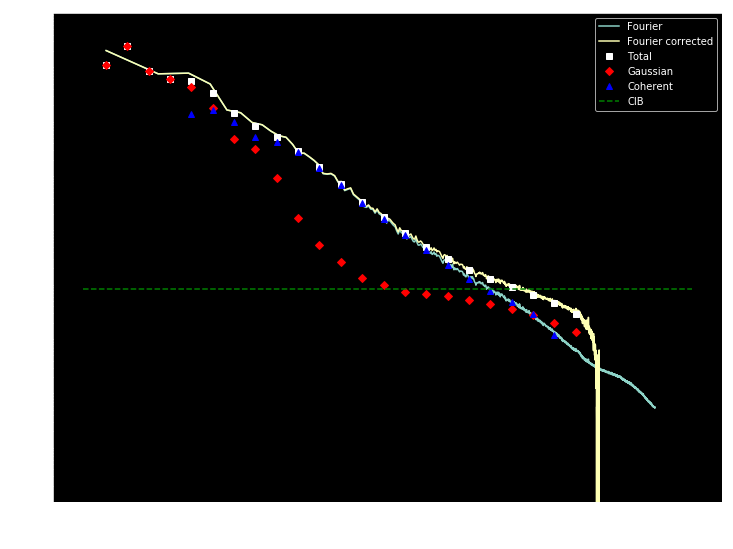

In [70]:
#Fourier power spectrum
#tab_k, spec_k = powspec(imr, reso=reso)

#Test on padding size
#ko= 5.336
#delta = (2.*np.sqrt(-2.*np.log(.75)))/ko
#a = ko / (wav_k * reso)
#N = 1.
#for j in range(M):
#    S1a[0,j]=np.sum(S11a[j,:,:]) / (newdim[0] * newdim[1])

#Conversion in Jy^2/sr
spec_kJy = spec_k*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12
S1aJy = S1a*(HDU[0].header['CDELT2']**2/3.2828e3)*1.e12

#Noise
Noise = S1aJy[0,23]

#CIB level Viero et al. 2013a
CIB = 8.5e3

#Plot Fourier power spectrum
plt.figure(figsize(12,9))
plt.plot(tab_k, spec_kJy, label='Fourier')
plt.plot(tab_k, (spec_kJy-Noise)/spec_beamn, label='Fourier corrected')
plt.plot(wav_k,(S1aJy[0,:]-Noise)/BS1an,'s',color='white',label='Total')
plt.plot(wav_k,(S1aJy[2,:]-Noise)/BS1an,'D',color='red',label='Gaussian')
plt.plot(wav_k,(S1aJy[1,:]-Noise)/BS1an,'^',color='blue',label='Coherent')
plt.plot([3e-3,1e1],[CIB,CIB],'--',color='green',label='CIB')
plt.xscale('log')
plt.yscale('log')
plt.ylim([1e0,1e9])
plt.xlabel('$k$ (arcmin$^{-1}$)')
plt.ylabel('$P(k)$ (Jy$^2$ sr$^{-1}$)')
plt.legend()

plt.savefig('/Users/robitaij/postdoc/Herschel/OT/analysis/draco250_pow_spec_seg.pdf',dpi=150,bbox_inches='tight')

In [73]:
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/wav_k_draco_3000.npy',wav_k)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/S1a_draco_3000.npy',S1a)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/S11a_draco_3000.npy',S11a)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/wt_draco_3000.npy',wt)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/tab_k_draco_3000.npy',tab_k)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/spec_k_draco_3000.npy',spec_k)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/spec_beamn_draco_3000.npy',spec_beamn)
np.save('/Users/robitaij/postdoc/Herschel/OT/analysis/BS1an_draco_3000.npy',BS1an)

In [5]:
wav_k = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/wav_k_draco_3000.npy')
S1a = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/S1a_draco_3000.npy')
S11a = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/S11a_draco_3000.npy')
wt = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/wt_draco_3000.npy')
tab_k = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/tab_k_draco_3000.npy')
spec_k = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/spec_k_draco_3000.npy')
spec_beamn = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/spec_beamn_draco_3000.npy')
BS1an = np.load('/Users/robitaij/postdoc/Herschel/OT/analysis/BS1an_draco_3000.npy')

INFO: Auto-setting vmin to -3.109e+00 [aplpy.core]
INFO: Auto-setting vmax to  4.469e+00 [aplpy.core]
INFO: Auto-setting vmin to -4.542e+00 [aplpy.core]
INFO: Auto-setting vmax to  1.257e+01 [aplpy.core]


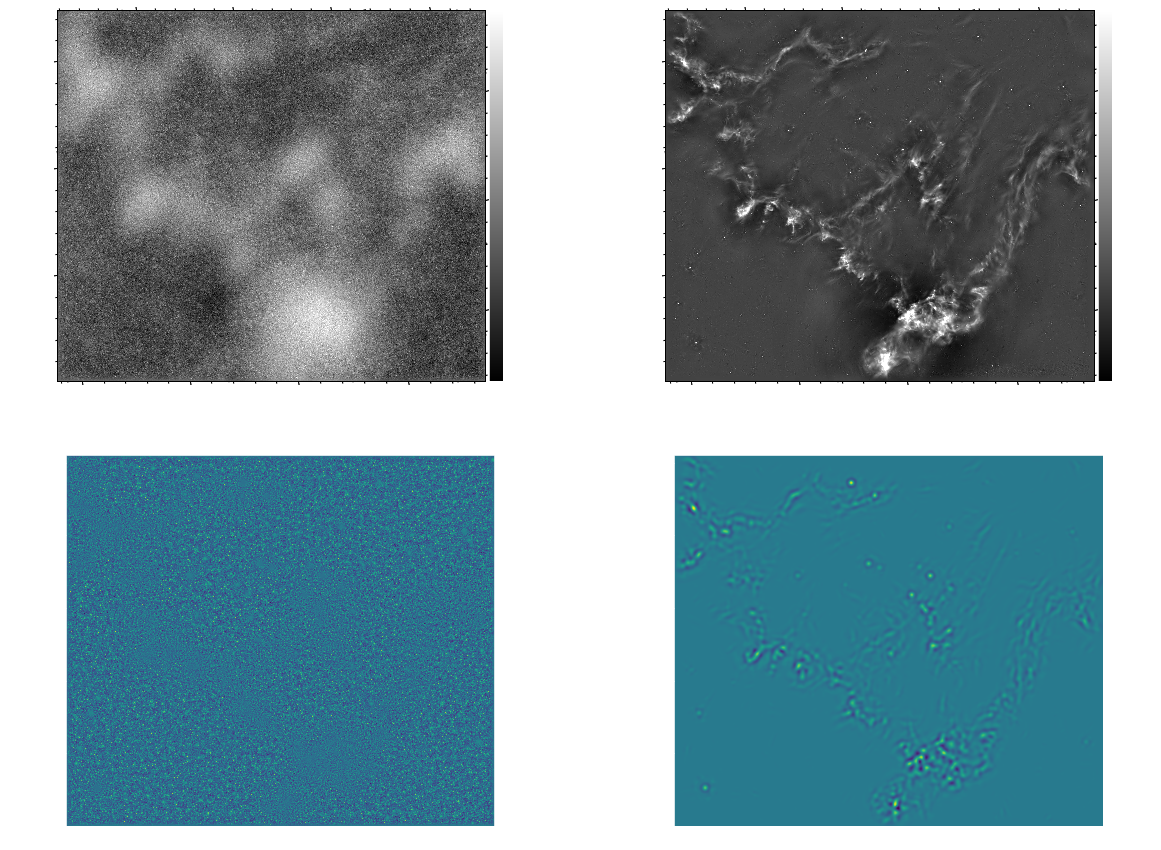

In [68]:
M = wav_k.shape[0]

coherent = np.sum(wt[M:2*M,:,:],axis=0)
Gaussian = np.sum(wt[2*M:3*M,:,:],axis=0)
imcib = np.sum(wt[2*M+12:2*M+22,:,:],axis=0).real

fits.writeto('/Users/robitaij/postdoc/Herschel/OT/analysis/draco_250_cohe.fits',\
            coherent.real,HDU[0].header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/OT/analysis/draco_250_gaussian.fits',\
            Gaussian.real,HDU[0].header,overwrite=True)

fig_all = plt.figure(1, figsize=(20,15))

figfile = '/Users/robitaij/postdoc/Herschel/OT/analysis/draco_250_gaussian.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 1))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()

figfile = '/Users/robitaij/postdoc/Herschel/OT/analysis/draco_250_cohe.fits'
fig = aplpy.FITSFigure(figfile, figure=fig_all, convention='calabretta',subplot=(2, 2, 2))
fig.show_colorscale(cmap='gray')
fig.tick_labels.set_xformat('dd.d')
fig.tick_labels.set_yformat('dd.d')
fig.add_colorbar()
fig.colorbar.set_axis_label_text(r'H$_2$ cm$^{-2}$')

plt.subplot(2,2,3)
imshow(imcib,origin='below')
fits.writeto('/Users/robitaij/postdoc/Herschel/OT/analysis/draco_250_cib.fits',\
            imcib,HDU[0].header,overwrite=True)
fits.writeto('/Users/robitaij/postdoc/Herschel/OT/analysis/draco_250_subcib.fits',\
            im-imcib,HDU[0].header,overwrite=True)

plt.subplot(2,2,4)
imshow(np.sum(wt[M+13:M+16,:,:],axis=0).real,origin='below')

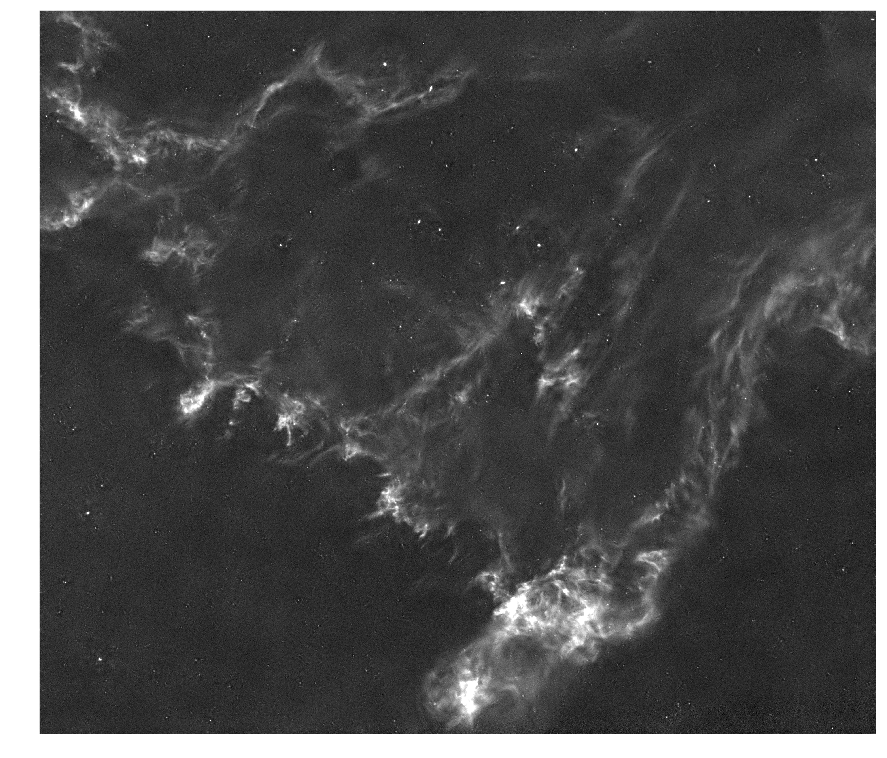

In [69]:
figure(figsize=(15,15))
imshow(im - imcib,cmap='gray',origin='lower',vmin=-1.625,vmax=1.751e+01)